# Laboratory 07: Train, Validate, Test and Infer
## Putting It All Together

Thus far we talked about building, training, validating, testing and inference with deep neural networks on separate examples. While the discussions occurred in the context of fully connected networks, in practice all these tasks are performed for any machine learning model. So the goal here is to put them all together for neural networks as you would normally do in practice.

For this we will again use the FashionMNIST dataset, so without further ado here are the usual imports you will need: 


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

# This will be explained in future notebooks, but feel free to look ahead in the documation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

As usual, the first step you need to tackle is to implement the functionality that does the work required to prepare the data for your model. Since the goal is to do this in a generalized manner, you need define a function that outputs the loaders used throughout the hole process, namely: train, validate and test.

### Exercise 1

Implement in PyTorch the `train_valid_split` function that creates the *train/validation loaders based on:
- dataset - the dataset to splittrain_valid_split
- valid_size - the parameter that specifies the split threshold 
- batch_size - the size of the batch

**Note:** Since FashionMNIST already has a dedicated test set directly available through torchvision, we don't need to separate it out from the train set. However, in general you will have all data in a single dataset. Hence, you would need to implement a 3 way split for training, validation and testing.

In [ ]:
# TODO 1.1. Implement train_valid_split()

def train_valid_split(dataset, valid_size = 0.2, batch_size = 32):
    ds_len = len(dataset)
    idxs = list(range(ds_len))
    np.random.shuffle(idxs)
    split = int(np.floor(valid_size * ds_len))
    train_idxs, valid_idxs = idxs[split:], idxs[:split]

    train_sampler = SubsetRandomSampler(train_idxs)
    valid_sampler = SubsetRandomSampler(valid_idxs)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,
          sampler = train_sampler)
    valid_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, 
          sampler = valid_sampler)
    
    return train_loader, valid_loader
    

### Exercise 2

In the second step you have to implement the neural network architecture of your model. While in the previous lab you directly created the network architecture using the `torch.nn` API, here you have to do it in a more general manner. Considering the fact that neural networks are composed of many different blocks (which themselves are composed of different primitives such as layers, activations, normalization and so on), a sensible thing to do is to define a network block making function.  


For example, last time in the architecture from exercise 4 (see Figure below) each hidden layer was followed by a ReLu activation function, while the output layer was followed by a softmax activation to obtain the class probabilities. Moreover, after each hidden layer you applied dropout, except for the output layer.

<img src="res/fashion-nn.png" width=500px>

You can structure this in either a hidden block - which combines a linear layer, ReLu and dropout - or an output block - which combines a linear layer with softmax. Hence, generally you can implement a `make_block` function that outputs the appropriate network block based on a selection parameter. Of course, here our parameter will be binary between hidden and output (True/False). However, generally you will have many types of hidden blocks, so this parameter may have an enumeration of options.

Implement the `make_block()` function following the TODO's bellow.

**Note:** [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [nn.LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax) and [nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout) are useful here. Also, recall that you can combine neural network operations in a sequence using [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential).



In [ ]:
# TODO 2.1. Implement the hidden and output blocks
def make_block(input_dim, output_dim, p_dropout = 0.2, final_layer = False):
    if not final_layer:
        return nn.Sequential(
             # Complete here
             nn.Linear(input_dim, output_dim),
             nn.ReLU(),
             nn.Dropout(p_dropout)
        )
    else:
        return nn.Sequential(
            # Complete here
             nn.Linear(input_dim, output_dim),
             nn.LogSoftmax(dim = 1)
        )

In [ ]:
# TODO 2.2. Use make block to implement the network architecture
class Network(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(Network, self).__init__()
        # Complete here
        net_blocks = [make_block(input_dim, hidden_dims[0]),
                      make_block(hidden_dims[0], hidden_dims[1]),
                      make_block(hidden_dims[1], hidden_dims[2]),
                      make_block(hidden_dims[2], output_dim, final_layer = True)]
        self.net = nn.Sequential(*net_blocks)
        
    def forward(self, x):
        x = self.net(x)
        return x
    
    def __repr__(self):
        return self.net.__repr__()
    
    def __str__(self):
        return self.net.__str__()

### Exercise 3

Most often, training a neural network model takes quite a long time and its prone to a number learning problems with respect to generalization. Thus, you usually want save the model parameters that achieve the best (or a few top best) validation results. This will let you reuse these parameters at test/inference time or provide model parameter initialization points for architecture tweaks you may do latter on. So, in this exercise implement saving/loading functions for your the model you defined above.

Follow the TODO's below.

In [ ]:
# TODO 3.1. Implement the function to save your model
def save_model(model, checkpoint='checkpoint.pth'):
    
    # TODO 3.1.a) Create a model dictionary out of all its children (name, layer) pairs
    checkpoint_model = model.named_children

    # TODO 3.1.b) Create a dictionary to save the model and its state
    checkpoint_dict = {'model' : checkpoint_model,
                       'state_dict' : model.state_dict()}
    
    # TODO 3.1.c) Save the dictonary a file
    torch.save(checkpoint_dict, checkpoint)
    

# TODO 3.2. Implement the function to load your model
def load_model(model = None, checkpoint='checkpoint.pth'):
    # TODO.3.2.a) load the model from the file
    checkpoint_dict =  torch.load(checkpoint)
    
    if model is None:
        # TODO 3.2. b) use nn.Sequential object to re-create the model
        model = nn.Sequential(checkpoint_dict['model'])
    
    # TODO: 3.2.c) Load the state in your model
    model.load_state_dict(checkpoint_dict['state_dict'])
    
    return model

### Exercise 4

In order to implement the training loop we have to define several components, namely:
1. hyper-parameters specific to the training process you want to implement, such as batch size, learning rate, and so on.
2. prepare the data loaders based on your dataset with appropriate transformations.
3. instantiate the architecture you want to train.
4. define the criterion (i.e. loss function) and the optimizer you want to use.

Having completed all these steps you can then implement the actual training process in a function in order to reuse it as needed. So, bellow you'll start with the hyper-parameters definition. 

**Note:** You can chose any values you see fit for these hyper-parameters, but do it wisely.

In [ ]:
# TODO 4.1. Define the hyper-parameters
batch_size = 64
valid_size = 0.2

input_dim = 784
hidden_dims = [256, 128, 64]
output_dim = 10

epochs = 10
learning_rate = 0.003

Now in the position to create the loaders, i.e. train/valid/test loaders. To do this implement the following steps:
- download the FashionMNIST train and test sets, in `./datasets/`, while applying the appropriate transformation 
- call `train_valid_test_split()` to create train/valid loaders
- create the test set loader

In [ ]:
# TODO 4.2.a) Create the apropriate transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# TODO 4.2.b) Get the training set and create train/validate loaders 
train_set = datasets.FashionMNIST('./datasets/', download = True, train = True, transform = transform)
train_loader, valid_loader = train_valid_split(train_set, valid_size = valid_size, batch_size = batch_size)

# TODO 4.2.c) Get the test set and create it's loader
test_set = datasets.FashionMNIST('./datasets/', download = True, train = False, transform = transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

Now, the last pieces you need for training are the model, the loss function and the SGD (based) optimizer. Here we deal with multi-class classification, so the criterion you need to use is the *negative log loss* `NLLLoss()`. Whereas, for the optimizer use `Adam()` such that the training is faster and more stable.

In [ ]:
# TODO 4.3. Create the model, criterion and optimizer
model = Network(input_dim, hidden_dims, output_dim)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# Comment this line out if you have any trouble
model = model.to(device)

Ok, now you have all the pieces and its time to put them together. In order to this you need to implement train/validate steps for training, while keeping track of the training/validation losses and saving the best check point. 

Follow the TODO's and comments below to complete these steps.

In [ ]:
# TODO 4.4. Implement the training function
def train(model, criterion, optimizer, train_loader, valid_loader, epochs=10):
    
    # Keeping track variabiles
    best_valid_loss = np.Inf
    train_losses, valid_losses = [], []
    
    # The training loop:
    for epoch in range(epochs):
        # Initializing the training loss for this epoch
        training_loss = 0
        for images, labels in train_loader:
            images = torch.flatten(images, start_dim = 1)
            # Comment this line out if you have any trouble
            images, labels = images.to(device), labels.to(device)
            # TODO 4.4.a) Implement the actual training for this batch
            optimizer.zero_grad()
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            
            # TODO 4.4.b) Keep track of invidual batch losses in this epoch.
            training_loss += loss.item()

        
        # Intializing the validation loss and accuracy for this epoch
        valid_loss = 0
        accuracy = 0

        # Turning off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in valid_loader:
                # Comment this line out if you have any trouble
                images, labels = images.to(device), labels.to(device) 
                images = torch.flatten(images, start_dim = 1)
                
                # TODO 4.4.c) Implement the actual validation for this batch
                log_ps = model(images)
                valid_loss += criterion(log_ps, labels)
                
                # TODO 4.4.d) Compute the accuracy
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = (top_class == labels.view(*top_class.shape))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()

        # TODO 4.4.e) Save the best model thus far
        if valid_loss < best_valid_loss:
          save_model(model)
          best_valid_loss = valid_loss
        
        # TODO 4.4.f) Save the best model thus far
        train_losses.append(training_loss/len(train_loader))
        valid_losses.append(valid_loss/len(valid_loader))
        
        # Printing info in this epoch
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Validation Loss: {:.3f}.. ".format(valid_losses[-1]),
              "Validation Accuracy: {:.3f}".format(accuracy/len(valid_loader)))
    print("Done!")
    
    return train_losses, valid_losses

# Doing the training loop - you may want to play with the number of epochs to train
train_losses, valid_losses = train(model, criterion, optimizer, train_loader, valid_loader, epochs=10)

Epoch: 1/10..  Training Loss: 0.623..  Validation Loss: 0.451..  Validation Accuracy: 0.833
Epoch: 2/10..  Training Loss: 0.491..  Validation Loss: 0.461..  Validation Accuracy: 0.833
Epoch: 3/10..  Training Loss: 0.458..  Validation Loss: 0.406..  Validation Accuracy: 0.853
Epoch: 4/10..  Training Loss: 0.438..  Validation Loss: 0.427..  Validation Accuracy: 0.843
Epoch: 5/10..  Training Loss: 0.426..  Validation Loss: 0.389..  Validation Accuracy: 0.863
Epoch: 6/10..  Training Loss: 0.417..  Validation Loss: 0.380..  Validation Accuracy: 0.864
Epoch: 7/10..  Training Loss: 0.404..  Validation Loss: 0.385..  Validation Accuracy: 0.864
Epoch: 8/10..  Training Loss: 0.405..  Validation Loss: 0.389..  Validation Accuracy: 0.860
Epoch: 9/10..  Training Loss: 0.400..  Validation Loss: 0.362..  Validation Accuracy: 0.867
Epoch: 10/10..  Training Loss: 0.389..  Validation Loss: 0.379..  Validation Accuracy: 0.860
Done!


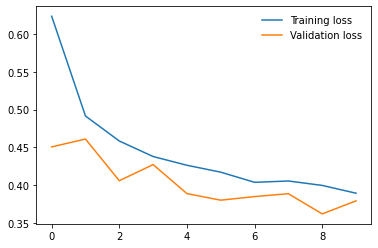

In [ ]:
# Plotting the losses
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

### Exercise 5

Congrats! You have now trained your model. However, you still need to test it and check its generalization capability. Since we don't necessarily want to use our latest model parameters, you can use `load_model(model, checkpoint)` to instantiate your model with the best parameters found during the training process.

Without further ado, implement the testing function below by following the TODO's.

In [ ]:
# TODO 5.1. Implement the test function
def test(model, test_loader, criterion, checkpoint='checkpoint.pth'):
    
    # TODO 5.1.a) Load the best model parameters
    model = load_model(model, checkpoint)
    
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        model.eval()
        for images, labels in test_loader:
            # TODO 5.1.b) Compute the test loss and accuracy
            images = torch.flatten(images, start_dim = 1)
            log_ps = model(images)
            test_loss += criterion(log_ps, labels)
                
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = (top_class == labels.view(*top_class.shape))
            accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # Printing the results
        print("Test Loss: {:.3f} ..".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

# Doing the actual testing
model = Network(input_dim, hidden_dims, output_dim)
test(model, test_loader, criterion)

Test Loss: 0.393 .. Test Accuracy: 0.862


Finally, if your satisfied with the generalization capabilities of your model you can used it to make predictions. At your disposal are some real (standalone) images acquired from the web. The images are located in the `datasets` folder and come in different shapes and sizes. The names of these images are numbers in the interval 0 - 7. Hence, aside from the usual `ToTensor()` and `Normalize()` transformations, you need to bring these images in the format expected by your model. To do this you may find useful the  [`Grayscale()`](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=grayscale#torchvision.transforms.Grayscale) and [`Resize()`](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=resize#torchvision.transforms.Resize) transformations.

In [ ]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "FashionMNIST":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

Class distribution:  [[0.001 0.    0.134 0.    0.713 0.    0.152 0.    0.    0.   ]]


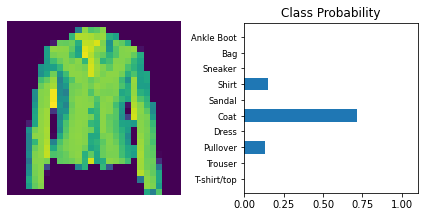

In [ ]:
from PIL import Image
import PIL.ImageOps
import helper

image = PIL.ImageOps.invert(Image.open('./datasets/0.jpg').convert("RGB"))

# TODO 5.2.a) Create the appropriate transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),
                                transforms.Grayscale(), transforms.Resize((28, 28))])

# TODO 5.2.b) Apply the transformation
fashion_image = transform(image)

# TODO 5.2.c) Instantiate the model
model = Network(input_dim, hidden_dims, output_dim)

# TODO 5.2.d) Load its best parameters
model = load_model(model)

# TODO 5.2.e) Apply the model to fashion_image and save results in log_ps
# Note: You still have to tell pytorch not compute gradients  
# and put your model in eval mode   

fashion_image = torch.flatten(fashion_image, start_dim = 1)
with torch.no_grad():
  model.eval()
  log_ps = model(fashion_image)

# Here's how your prediction looks like   
ps = torch.exp(log_ps)
print('Class distribution: ',np.around(ps.numpy(), 3))
# Plot the image and probabilities
view_classify(fashion_image, ps, 'FashionMNIST')